In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import time
import warnings
from joblib import Parallel, delayed
import tracemalloc


In [2]:
# Funzione per convertire l'uso della memoria in unità appropriate
def format_memory_usage(mem_usage):
    if mem_usage >= 1024 ** 3:
        return f"{mem_usage / (1024 ** 3):.2f} GB"
    else:
        return f"{mem_usage / (1024 ** 2):.2f} MB"

# Funzione per monitorare l'uso della memoria durante una funzione
def monitor_memory_usage(func, *args, **kwargs):
    tracemalloc.start()
    result = func(*args, **kwargs)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return result, peak

# Funzione per il training e l'evaluation con monitoraggio della memoria
def train_and_evaluate(train_idx, test_idx, X, y, n_estimators):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    start_train = time.time()
    _, training_mem_usage = monitor_memory_usage(model.fit, X_train, y_train)
    end_train = time.time()

    start_eval = time.time()
    y_pred, eval_mem_usage = monitor_memory_usage(model.predict, X_test)
    end_eval = time.time()

    report = classification_report(y_test, y_pred, digits=4, output_dict=True, zero_division=0)

    training_time = end_train - start_train
    evaluating_time = end_eval - start_eval
    total_mem_usage = training_mem_usage + eval_mem_usage

    return report, training_time, training_mem_usage, evaluating_time, eval_mem_usage, total_mem_usage


In [3]:

# Inizializzazione del dataset e dei parametri
DATA_PATH = "/users/mik2002/som/dataset-processed UNSW-NB15/"
DATA_FILE = "dataset-processed-UNSW-NB15.csv"

# Carichiamo il dataset combinato e processato
df_dataset = pd.read_csv(DATA_PATH + DATA_FILE)

# Drop the 'attack_cat' column se ancora presente (può essere già stato rimosso nel dataset processato)
if 'attack_cat' in df_dataset.columns:
    df_dataset = df_dataset.drop(columns=['attack_cat'])

# Display label distribution
print("Distribution:")
display(df_dataset["label"].value_counts())


Distribution:


label
1    164673
0     93000
Name: count, dtype: int64

In [4]:

# Parametri per la Random Forest
n_estimators = 100
sampling_fractions = [0.1, 0.3, 0.5, 0.7, 1]  # Diversi frazioni di campionamento
results = []


Evaluating for sampling fraction: 0.1



Average Metrics Across All Folds:
****************************

Sampling Fraction: 0.1

Class 0:
precision: 0.9145
recall: 0.8895
f1-score: 0.9018

Class 1:
precision: 0.9385
recall: 0.9531
f1-score: 0.9457

Class macro avg:
precision: 0.9265
recall: 0.9213
f1-score: 0.9238

Class weighted avg:
precision: 0.9299
recall: 0.9301
f1-score: 0.9299

accuracy: 0.9301
Average Training Time: 0 minutes and 2.69 seconds
Average Training Memory Usage: 5.85 MB
Average Evaluating Time: 0 minutes and 0.05 seconds
Average Evaluating Memory Usage: 1.21 MB
Average Total Memory Usage: 7.06 MB
---------------------------------------
Evaluating for sampling fraction: 0.3

Average Metrics Across All Folds:
****************************

Sampling Fraction: 0.3

Class 0:
precision: 0.9142
recall: 0.9023
f1-score: 0.9082

Class 1:
precision: 0.9452
recall: 0.9521
f1-score: 0.9486

Class macro avg:
precision: 0.9297
recall: 0.9272
f1-score: 0.9284

Class weighted avg:
precision: 0.9340
recall: 0.9341
f1-score:

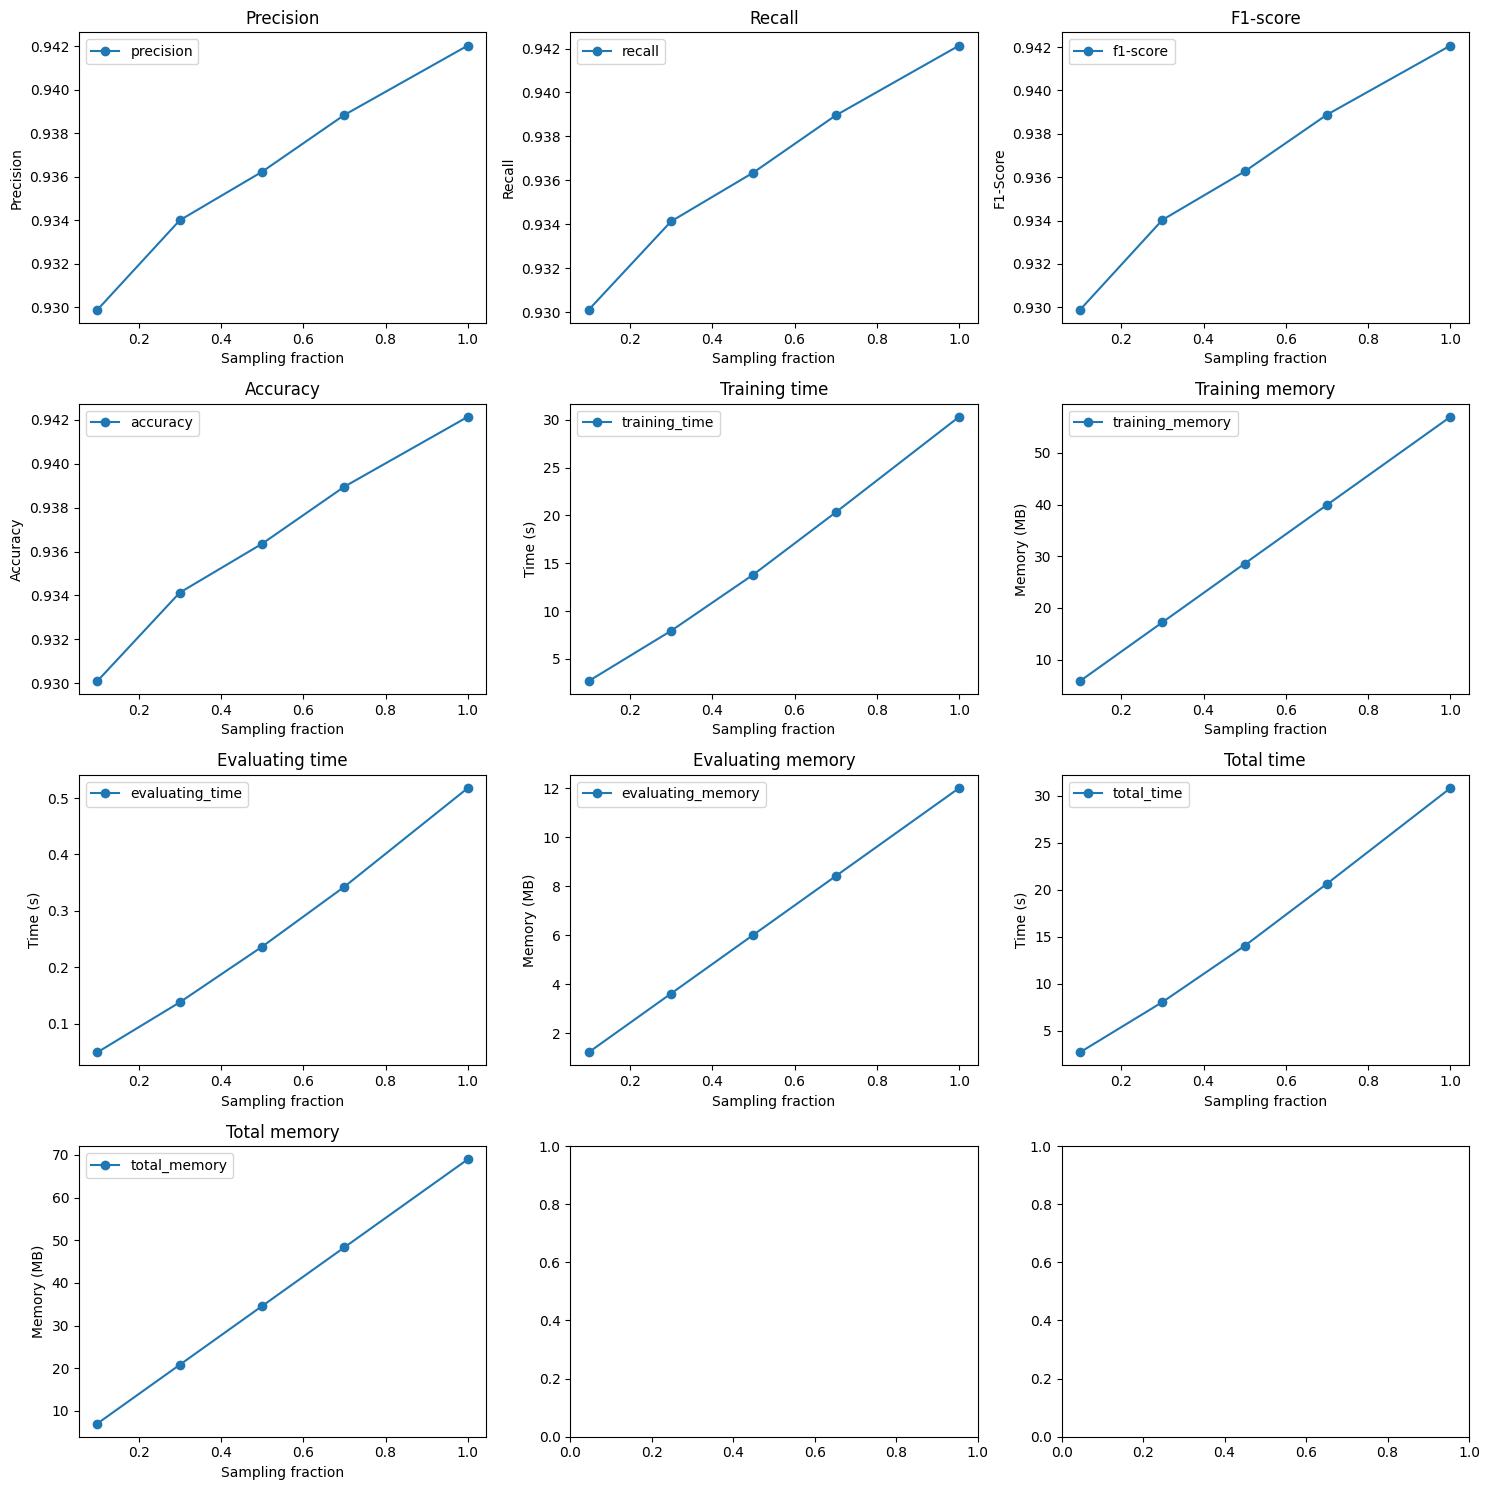

In [5]:

# Funzione wrapper per il parallelismo
def parallel_train_and_evaluate(train_idx, test_idx, data, target, n_estimators):
    report, training_time, training_mem_usage, evaluating_time, eval_mem_usage, total_mem_usage = train_and_evaluate(train_idx, test_idx, data, target, n_estimators)
    return report, training_time, training_mem_usage, evaluating_time, eval_mem_usage, total_mem_usage

# Inizializzazione del KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop su diverse frazioni di campionamento
for frac in sampling_fractions:
    print(f"Evaluating for sampling fraction: {frac}")
    
    # Esegui campionamento casuale stratificato mantenendo le proporzioni delle classi
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", DeprecationWarning)
        sampled_df = df_dataset.groupby("label", group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=42))

    scaler = MinMaxScaler()
    data = scaler.fit_transform(sampled_df.iloc[:, :-1])
    target = sampled_df.iloc[:, -1].values

    # Split del dataset con K-Fold e parallelismo
    parallel_results = Parallel(n_jobs=-1)(delayed(parallel_train_and_evaluate)(train_idx, test_idx, data, target, n_estimators) for train_idx, test_idx in kf.split(data))
        
    reports, training_times, training_mem_usages, evaluating_times, eval_mem_usages, total_mem_usages = zip(*parallel_results)
        
    # Aggrega metriche dai report
    class_metrics = {}
    accuracies = []
    for report in reports:
        accuracies.append(report['accuracy'])
        for key, metrics in report.items():
            if key.isdigit() or key in ['macro avg', 'weighted avg']:
                if key not in class_metrics:
                    class_metrics[key] = {m: [] for m in metrics.keys() if m != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        class_metrics[key][metric].append(value)

    # Calcola medie e prepara output formattato
    averages = {key: {metric: np.mean(values) for metric, values in metrics.items()} for key, metrics in class_metrics.items()}
    averages['accuracy'] = np.mean(accuracies)

    # Calcola i tempi medi di training e valutazione e l'uso della memoria
    avg_training_time = np.mean(training_times)
    avg_training_mem_usage = np.mean(training_mem_usages)
    avg_evaluating_time = np.mean(evaluating_times)
    avg_eval_mem_usage = np.mean(eval_mem_usages)
    avg_total_mem_usage = np.mean(total_mem_usages)

    results.append((frac, averages, avg_training_time, avg_training_mem_usage, avg_evaluating_time, avg_eval_mem_usage, avg_total_mem_usage))

    # Mostra i risultati per ogni frazione di campionamento
    print("\nAverage Metrics Across All Folds:")
    print("****************************")
    print(f"\nSampling Fraction: {frac}")
    for class_id, class_metrics in averages.items():
        if isinstance(class_metrics, dict):
            print(f"\nClass {class_id}:")
            for metric, value in class_metrics.items():
                print(f"{metric}: {value:.4f}")
        else:
            print(f"\n{class_id}: {class_metrics:.4f}")

    # Mostra i tempi medi di training e valutazione e l'uso della memoria
    minutes_train, seconds_train = divmod(avg_training_time, 60)
    minutes_eval, seconds_eval = divmod(avg_evaluating_time, 60)
    print(f"Average Training Time: {int(minutes_train)} minutes and {seconds_train:.2f} seconds")
    print(f"Average Training Memory Usage: {format_memory_usage(avg_training_mem_usage)}")
    print(f"Average Evaluating Time: {int(minutes_eval)} minutes and {seconds_eval:.2f} seconds")
    print(f"Average Evaluating Memory Usage: {format_memory_usage(avg_eval_mem_usage)}")
    print(f"Average Total Memory Usage: {format_memory_usage(avg_total_mem_usage)}")
    print("---------------------------------------")

# Funzione per creare i grafici
def plot_metrics(results):
    fractions = [res[0] for res in results]
    metrics = ["precision", "recall", "f1-score", "accuracy", "training_time", "training_memory", "evaluating_time", "evaluating_memory", "total_time", "total_memory"]
    
    metric_values = {metric: [] for metric in metrics}
    
    for result in results:
        frac, averages, avg_training_time, avg_training_mem_usage, avg_evaluating_time, avg_eval_mem_usage, avg_total_mem_usage = result
        metric_values["precision"].append(averages["weighted avg"]["precision"])
        metric_values["recall"].append(averages["weighted avg"]["recall"])
        metric_values["f1-score"].append(averages["weighted avg"]["f1-score"])
        metric_values["accuracy"].append(averages["accuracy"])
        metric_values["training_time"].append(avg_training_time)
        metric_values["training_memory"].append(avg_training_mem_usage / (1024 ** 2))  # Convert to MB
        metric_values["evaluating_time"].append(avg_evaluating_time)
        metric_values["evaluating_memory"].append(avg_eval_mem_usage / (1024 ** 2))  # Convert to MB
        metric_values["total_time"].append(avg_training_time + avg_evaluating_time)
        metric_values["total_memory"].append(avg_total_mem_usage / (1024 ** 2))  # Convert to MB
    
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
    axes = axes.flatten()
    
    y_labels = {
        "precision": "Precision",
        "recall": "Recall",
        "f1-score": "F1-Score",
        "accuracy": "Accuracy",
        "training_time": "Time (s)",
        "training_memory": "Memory (MB)",
        "evaluating_time": "Time (s)",
        "evaluating_memory": "Memory (MB)",
        "total_time": "Time (s)",
        "total_memory": "Memory (MB)"
    }
    
    for i, metric in enumerate(metrics):
        axes[i].plot(fractions, metric_values[metric], marker='o', linestyle='-', label=metric)
        axes[i].set_title(metric.replace("_", " ").capitalize())
        axes[i].set_xlabel("Sampling fraction")
        axes[i].set_ylabel(y_labels[metric])
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

# Mostra i grafici delle metriche
plot_metrics(results)
